loading annotations into memory...
Done (t=0.41s)
creating index...
index created!
[]


IndexError: list index out of range

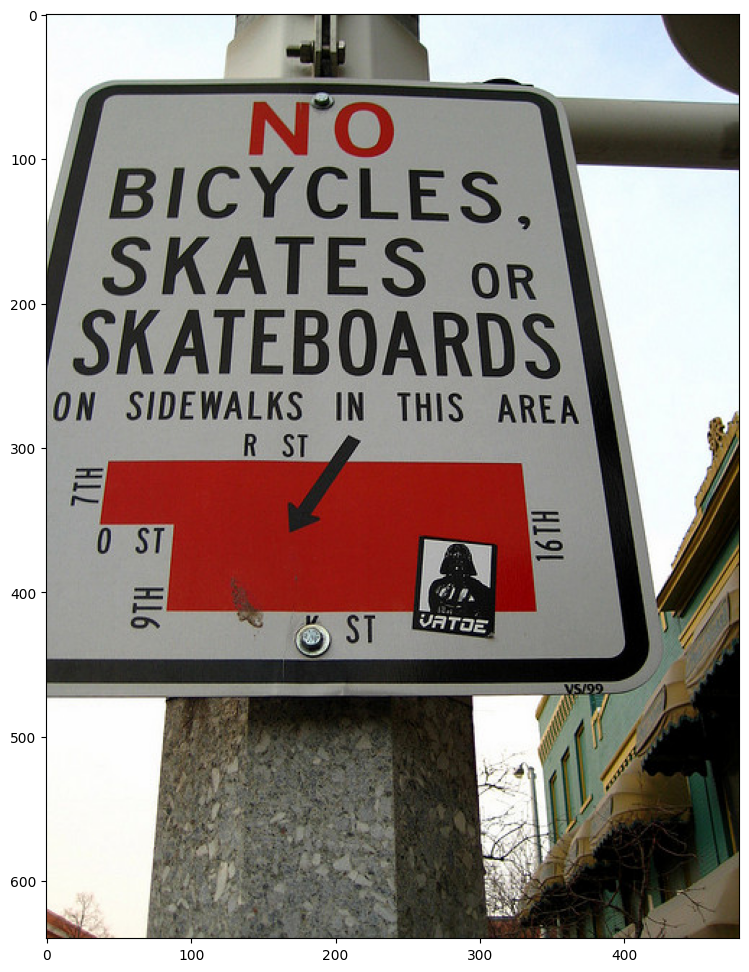

In [24]:
import cv2
import json
from pycocotools.coco import COCO
from pycocotools.mask import decode, frPyObjects
import matplotlib.pyplot as plt
import numpy as np

ann_path = "annotations/instances_val2017.json"
img_path = "val2017"

with open("all_cats.json", "r") as file:
    coco_80_cats = json.load(file)

coco = COCO(ann_path)

img_ids = coco.getImgIds()


for img_id in img_ids:
    ann_ids = coco.getAnnIds(imgIds=img_id)
    ann_data = coco.loadAnns(ann_ids)
    # print(ann_data)
    ann_image = coco.loadImgs(img_id)
    image_path = "val2017/{}".format(ann_image[0]['file_name'])
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, c = image.shape

    # print(height, width)

    plt.figure(figsize=(12, 12))
    plt.imshow(image)
    coco.showAnns(ann_data)

    ann_data_sorted = sorted(ann_data, key=lambda x: x['area'], reverse=True)

    masks = []
    for ann in ann_data_sorted:
        # print(list(coco_80_cats.keys())[list(coco_80_cats.values())])
        curr_id = [i for i in coco_80_cats if coco_80_cats[i][0] == ann['category_id']]
        cat80_id = int(curr_id[0])
        print(ann)
        if "segmentation" in ann and type(ann["segmentation"]) == list:
            for segmentation in ann["segmentation"]:
                rle = frPyObjects([segmentation], height, width)
                # print(rle)
                mask = decode(rle)  
                mask = mask * cat80_id
                masks.append(mask)
                # mask_blue = np.zeros_like(image)
                # mask_blue[mask.squeeze() == 1] = [0, 0, 255]
                # alpha = 0.8  # Degree of transparency - adjust as needed
                # blended = cv2.addWeighted(image, 1, mask_blue, alpha, 0)
                # plt.imshow(blended)
                # print(mask)
                print(mask.shape)

                # np.savetxt("poly2mask.txt", mask.squeeze(), fmt="%i")
    flattened_mask = masks[0]

    for sm in range(len(masks) - 1):
        next_layer = masks[sm + 1]
        flattened_mask[next_layer != 0] = next_layer[next_layer != 0]

    print(flattened_mask.shape)
    plt.imshow(flattened_mask.squeeze())
    np.save(
        "val2017_masks/{}_masks.txt".format(ann_image[0]['file_name'][:-4]), flattened_mask, fmt="%i"
    )
